In [1]:
import torch
import torchvision

In [43]:
# Setting up device for GPU usage if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}.")

n_epochs = 2
batch_size_train = 100
batch_size_test = 100
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

Running on cpu.


In [44]:
subset_indices = list(range(3000))
train_loader = torch.utils.data.DataLoader(
  torch.utils.data.Subset(torchvision.datasets.MNIST('/home/jovyan/', 
                             train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),subset_indices),
  batch_size=batch_size_train, shuffle=True)

subset_indices = list(range(500))
test_loader = torch.utils.data.DataLoader(
  torch.utils.data.Subset(torchvision.datasets.MNIST('/home/jovyan/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                                ])),subset_indices),
  batch_size=batch_size_test, shuffle=True)

In [45]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [46]:
example_data.shape

torch.Size([100, 1, 28, 28])

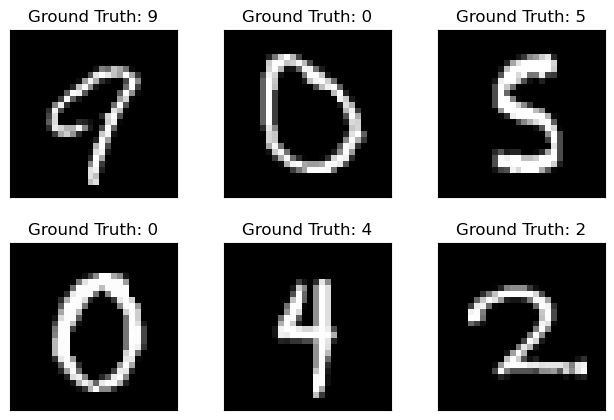

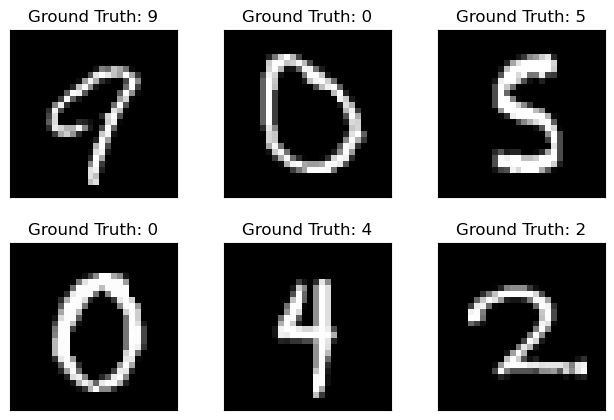

In [47]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [48]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Convolutional Neural Networks (CNNs)

Convolutional Neural Networks (CNNs) have revolutionized the field of computer vision. They are specifically designed to recognize visual patterns directly from pixel images with minimal preprocessing. CNNs are hierarchical models where neurons in one layer connect to neurons in the next layer in a limited fashion, somewhat like the receptive field in human vision.

![CNN Architecture](https://miro.medium.com/max/2824/1*uAeANQIOQPqWZnnuH-VEyw.jpeg)

A typical CNN architecture consists of:
1. **Convolutional Layers:** Apply convolution operation on the input layer to detect features.
2. **Activation Layers:** Introduce non-linearity to the model (typically ReLU).
3. **Pooling Layers:** Perform down-sampling operations to reduce dimensionality.
4. **Fully Connected Layers:** After several convolutional and pooling layers, the high-level reasoning in the neural network happens via fully connected layers.

Let's design a basic CNN for our dataset.


In [49]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

## Understanding Optimizers and Loss Functions

### Optimizers:

Optimizers are algorithms used to adjust the model's weights based on the gradient of the loss function. The goal is to minimize the loss. There are several optimizers available:

1. **SGD (Stochastic Gradient Descent)**: This is the basic form of the gradient descent algorithm. It updates the model's weights using the gradient of the loss function with respect to each weight.
    - Use: `torch.optim.SGD(model.parameters(), lr=learning_rate)`

2. **Momentum**: A variant of SGD that takes into account the previous steps, helping accelerate convergence and avoid local minima.
    - Use: `torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)`

3. **Adam**: Combines the advantages of two other extensions of SGD, namely AdaGrad and RMSProp. It adjusts the learning rate of each weight based on the historical gradient information.
    - Use: `torch.optim.Adam(model.parameters(), lr=learning_rate)`

4. **RMSProp**: Maintains a moving average of the squared gradient and divides the gradient by the root of this average.
    - Use: `torch.optim.RMSprop(model.parameters(), lr=learning_rate)`

### Loss Functions for Classification:

1. **Cross-Entropy Loss**: Used for multi-class classification. It quantifies the difference between the predicted probability distribution and the actual distribution.
    - Use: `nn.CrossEntropyLoss()`

2. **Binary Cross-Entropy Loss**: Specifically for binary classification tasks.
    - Use: `nn.BCELoss()`

3. **Hinge Loss (or Margin Loss)**: Used for "maximum-margin" classification, mostly for SVMs.
    - Use: `nn.HingeEmbeddingLoss()`

### Identifying the Task:

- **Classification**: In classification, the goal is to predict a class label for an input data point. If the dataset provides categorical labels (e.g., 'cat', 'dog', 'shirt', 'sandal'), it's a classification task.

- **Segmentation**: The goal in segmentation is to classify each pixel in an image. If the dataset provides images with colored regions indicating different objects or features, it's a segmentation task.

- **Regression**: Regression problems involve predicting a continuous value. If the dataset provides numerical values (e.g., house prices, stock prices) as labels, it's a regression task.

To discern between tasks, examine the dataset's labels and the problem's requirements. For example, if you're trying to predict an item's category from an image, it's classification. If predicting numerical values from features, it's regression.


In [50]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [51]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

## 3. Training Loop (Explained)

Training a neural network involves iteratively updating its weights to minimize the loss function. This process is typically achieved using gradient descent optimization algorithms. Here's an in-depth explanation of the training loop:

1. **Epochs**: An epoch represents one complete forward and backward pass of all the training examples. The number of epochs (`num_epochs`) is the number of times the learning algorithm will work through the entire training dataset. Usually a custom hyperparameter.

2. **Model Training Mode**: Neural networks can operate in different modes - training and evaluation. Some layers, like dropout, behave differently in these modes. Setting the model to training mode ensures that layers like dropout function correctly.

3. **Batch Processing**: Instead of updating weights after every training example (stochastic gradient descent) or after the entire dataset (batch gradient descent), we often update weights after a set of training examples known as a batch.

4. **Zeroing Gradients**: In PyTorch, gradients accumulate by default. Before calculating the new gradients in the current batch, we need to set the previous gradients to zero.

5. **Forward Pass**: The input data (images) are passed through the network, layer by layer, until we get the output. This process is called the forward pass.

6. **Calculate Loss**: Once we have the network's predictions (outputs), we compare them to the true labels using a loss function. This gives a measure of how well the network's predictions match the actual labels.

7. **Backward Pass**: To update the weights, we need to know the gradient of the loss function with respect to each weight. The backward pass computes these gradients.

8. **Update Weights**: The optimizer updates the weights based on the gradients computed in the backward pass.

This loop (forward pass, loss computation, backward pass, weight update) is repeated for every batch in the dataset, and the whole process is repeated for the specified number of epochs.



In [52]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), '/home/jovyan/results/model.pth')
      torch.save(optimizer.state_dict(), '/home/jovyan/results/optimizer.pth')

In [53]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [54]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/tmp/ipykernel_13933/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3192, Accuracy: 36/500 (7%)

Train Epoch: 1 [0/3000 (0%)]	Loss: 2.345391
Train Epoch: 1 [1000/3000 (33%)]	Loss: 2.299634
Train Epoch: 1 [2000/3000 (67%)]	Loss: 2.291617

Test set: Avg. loss: 2.2710, Accuracy: 90/500 (18%)

Train Epoch: 2 [0/3000 (0%)]	Loss: 2.275123
Train Epoch: 2 [1000/3000 (33%)]	Loss: 2.269192
Train Epoch: 2 [2000/3000 (67%)]	Loss: 2.233859

Test set: Avg. loss: 2.1816, Accuracy: 244/500 (49%)



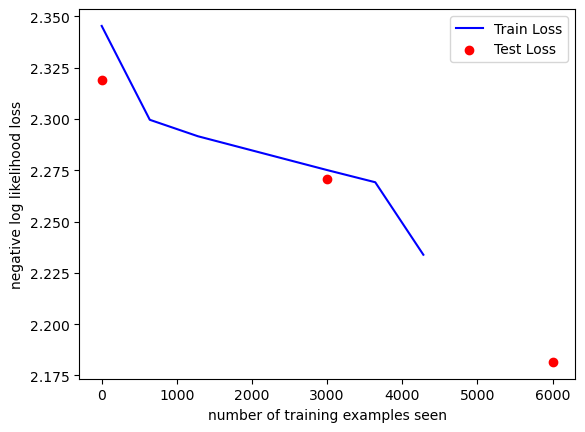

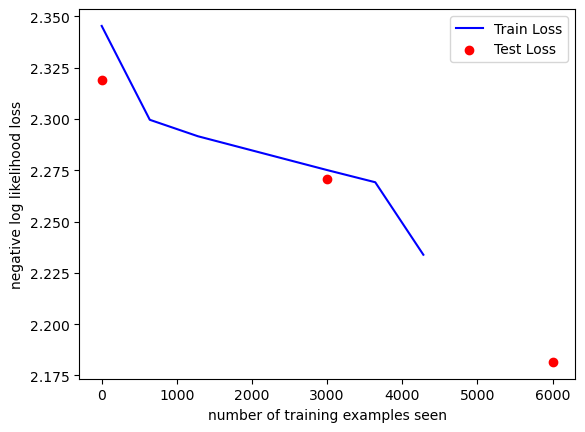

In [55]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [56]:
with torch.no_grad():
  output = network(example_data)

/tmp/ipykernel_13933/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


## Evaluation

Once our model is trained, it's crucial to evaluate its performance on unseen data. We'll:

1. Generate predictions for the test set.
2. Compute the overall accuracy.
3. Examine the model's performance in detail using a confusion matrix and classification report.

These tools will provide insights into specific areas where the model excels or might need improvement.

**Note:** We don't want to compute gradients, so we use `torch.no_grad()`.

/tmp/ipykernel_13933/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

              precision    recall  f1-score   support

        zero       0.68      0.36      0.47        42
         one       0.81      0.91      0.86        67
         two       0.79      0.67      0.73        55
       three       0.20      0.49      0.28        45
        four       0.57      0.15      0.23        55
        five       0.00      0.00      0.00        50
         six       0.30      0.88      0.45        43
       seven       0.84      0.65      0.74        49
       eight       0.00      0.00      0.00        40
        nine       0.47      0.57      0.52        54

    accuracy                           0.49       500
   macro avg       0.47      0.47      0.43       500
weighted avg       0.49      0.49      0.45       500



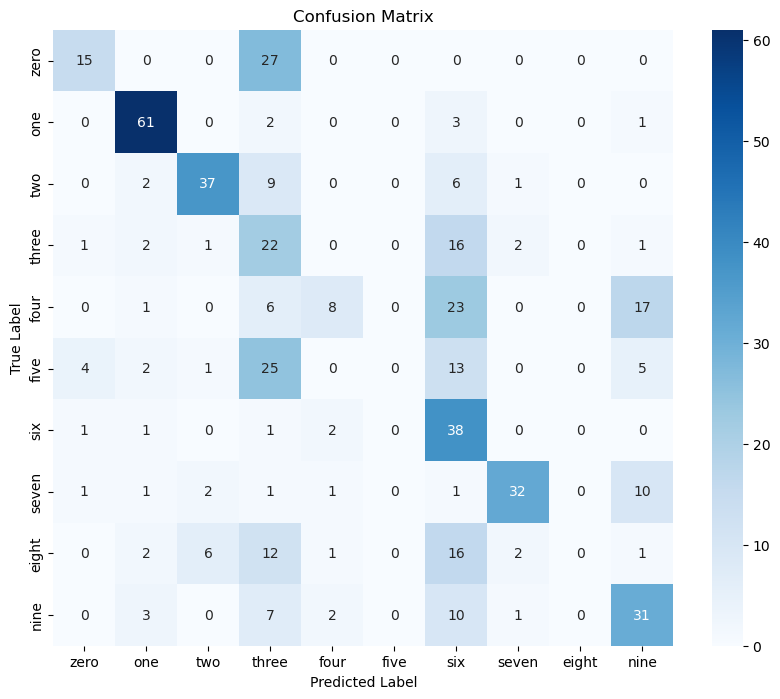

In [57]:
# Import necessary libraries:
# numpy for numerical operations
# sklearn.metrics for evaluation metrics like classification report and confusion matrix
# seaborn and matplotlib for data visualization
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


device
# Set the model to evaluation mode. This is important as certain layers like dropout behave differently during training and evaluation.
network.eval()

# Lists to store all predictions and true labels
all_preds = []
all_labels = []
# Define the class labels for the Fashion MNIST dataset.
classes = ('zero','one','two','three','four','five','six','seven','eight','nine')

# We don't want to compute gradients during evaluation, hence wrap the code inside torch.no_grad()
with torch.no_grad():
    # Iterate over all batches in the test loader
    for images, labels in test_loader:
        # Transfer images and labels to the computational device (either CPU or GPU)
        images, labels = images.to(device), labels.to(device)
        
        # Pass the images through the model to get predictions
        outputs = network(images)
        
        # Get the class with the maximum probability as the predicted class
        _, predicted = torch.max(outputs, 1)
        
        # Extend the all_preds list with predictions from this batch
        all_preds.extend(predicted.cpu().numpy())
        
        # Extend the all_labels list with true labels from this batch
        all_labels.extend(labels.cpu().numpy())

# Print a classification report which provides an overview of the model's performance for each class
print(classification_report(all_labels, all_preds, target_names=classes))

# Compute the confusion matrix using true labels and predictions
cm = confusion_matrix(all_labels, all_preds)

# Visualize the confusion matrix using seaborn's heatmap
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')  # x-axis label
plt.ylabel('True Label')       # y-axis label
plt.title('Confusion Matrix')  # Title of the plot
plt.show()                     # Display the plot


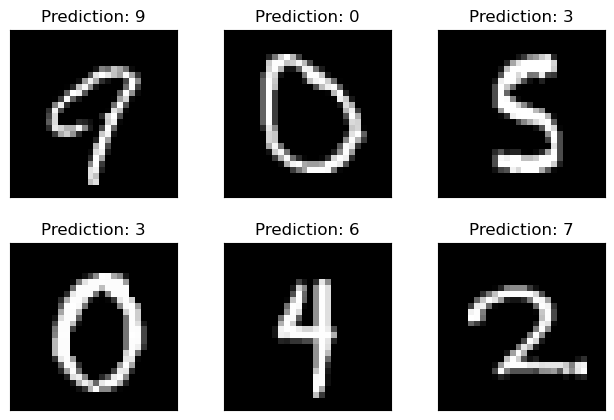

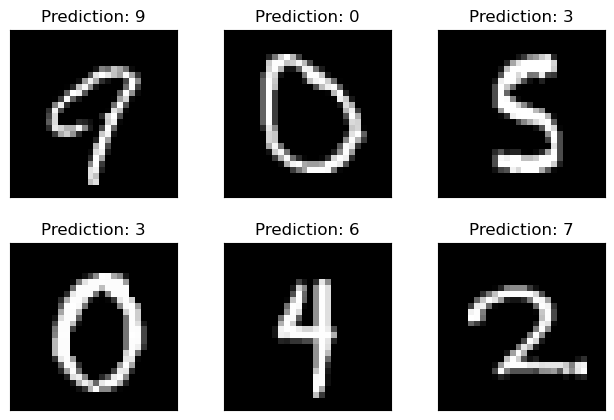

In [58]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig